#### <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:150%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > TABLE OF CONTENTS<br><div>  
* [IMPORTS](#1)
* [INTRODUCTION](#2)
    * [CONFIGURATION](#2.1)
    * [CONFIGURATION PARAMETERS](#2.2)    
    * [DATASET COLUMNS](#2.3)
* [PREPROCESSING](#3)
* [ADVERSARIAL CV](#4)
* [EDA AND VISUALS](#5) 
* [DATA TRANSFORMS](#6)
* [MODEL TRAINING](#7)    
* [ENSEMBLE AND SUBMISSION](#8)  
* [PLANNED WAY FORWARD](#9)     

<a id="1"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > IMPORTS<br> <div> 

In [1]:
%%time 

# Installing select libraries:-
from gc import collect;
from warnings import filterwarnings;
filterwarnings('ignore');
from IPython.display import clear_output;

!pip install -q category_encoders;
!pip install -q /kaggle/input/lightgbm410/lightgbm-4.1.0-py3-none-manylinux_2_28_x86_64.whl;
!pip install -q /kaggle/input/xgboost-2-0-0-whl/xgboost-2.0.1-py3-none-manylinux2014_x86_64.whl;
!pip install -q /kaggle/input/sklegowheelfile/autograd-1.6.2-py3-none-any.whl;
!pip install -q /kaggle/input/sklegowheelfile/scikit_lego-0.6.16-py2.py3-none-any.whl;

clear_output();

import xgboost as xgb, lightgbm as lgb, sklego;
print(f"---> Current XGBoost = {xgb.__version__} | LightGBM = {lgb.__version__} | SKLego = {sklego.__version__}");
print();
collect();

---> Current XGBoost = 2.0.1 | LightGBM = 4.1.0 | SKLego = 0.6.16

CPU times: user 5.94 s, sys: 1.18 s, total: 7.12 s
Wall time: 3min 1s


In [2]:
%%time

# General library imports:-
from copy import deepcopy;
import pandas as pd;
import numpy as np;
import re;
from scipy.stats import mode, kstest, normaltest, shapiro, anderson, jarque_bera;
from collections import Counter;
from itertools import product;
from colorama import Fore, Style, init;
from warnings import filterwarnings;
filterwarnings('ignore');
import joblib;
import os;

from tqdm.notebook import tqdm;
import seaborn as sns;
import matplotlib.pyplot as plt;
from matplotlib.colors import ListedColormap as LCM;
%matplotlib inline

from pprint import pprint;

print();
collect();
clear_output();

CPU times: user 373 ms, sys: 39.3 ms, total: 412 ms
Wall time: 511 ms


In [3]:
%%time 

# Importing model and pipeline specifics:-
from category_encoders import OrdinalEncoder, OneHotEncoder;

# Pipeline specifics:-
from sklearn.preprocessing import (RobustScaler, 
                                   MinMaxScaler, 
                                   StandardScaler, 
                                   FunctionTransformer as FT,
                                   PowerTransformer,
                                  );
from sklearn.impute import SimpleImputer as SI;
from sklearn.model_selection import (RepeatedStratifiedKFold as RSKF, 
                                     StratifiedKFold as SKF,
                                     KFold, 
                                     RepeatedKFold as RKF, 
                                     cross_val_score, cross_val_predict
                                    );
from sklearn.inspection import permutation_importance;
from sklearn.feature_selection import mutual_info_classif, RFE;
from sklearn.pipeline import Pipeline, make_pipeline;
from sklearn.base import BaseEstimator, TransformerMixin;
from sklearn.compose import ColumnTransformer;

# ML Model training:-
from sklearn.metrics import median_absolute_error as medae,  make_scorer;
from xgboost import DMatrix, XGBRegressor;
from lightgbm import LGBMRegressor, log_evaluation, early_stopping, LGBMClassifier;
from catboost import CatBoostRegressor, Pool;
from sklearn.ensemble import (RandomForestRegressor as RFR, 
                              ExtraTreesRegressor as ETR,
                              AdaBoostRegressor as ABR,
                              BaggingRegressor as BR,
                              HistGradientBoostingRegressor as HGBR,
                              GradientBoostingRegressor as GBR,
                             );
from sklearn.neighbors import KNeighborsRegressor as KNNR;
from sklearn.svm import SVR;
from sklearn.linear_model import Ridge as RIDGER;

# Ensemble and tuning:-
import optuna;
from optuna import Trial, trial, create_study;
from optuna.samplers import TPESampler, CmaEsSampler;
optuna.logging.set_verbosity = optuna.logging.ERROR;

from sklego.linear_model import LADRegression as LADR;

clear_output();
print();
collect();


CPU times: user 2.06 s, sys: 193 ms, total: 2.25 s
Wall time: 3.01 s


In [4]:
%%time 

# Setting rc parameters in seaborn for plots and graphs- 
# Reference - https://matplotlib.org/stable/tutorials/introductory/customizing.html:-
# To alter this, refer to matplotlib.rcParams.keys()

sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.75,  
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : '#0099e6',
         'axes.titlesize'       : 8.5,
         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,        
        });

# Color printing    
def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    "Prints color outputs using colorama using a text F-string";
    print(style + color + text + Style.RESET_ALL); 

# Making sklearn pipeline outputs as dataframe:-
from sklearn import set_config; 
set_config(transform_output = "pandas");
pd.set_option('display.max_columns', 50);
pd.set_option('display.max_rows', 50);

print();
collect();



CPU times: user 149 ms, sys: 0 ns, total: 149 ms
Wall time: 148 ms


<a id="2"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > INTRODUCTION<br><div> 

| Version<br>Number | Version Details | CV score| Single/ Ensemble|Public LB Score|
| :-: | --- | :-: | :-: |:-:|
| **V1** |* No scaling and null treatment <br> * No secondary features <br> * Used original data <br> * 5 x 2 RKF CV <br> * Tree based ML models and Optuna ensemble|0.543611|Optuna blend |0.51966|
| **V2** |* No scaling and null treatment <br> * No secondary features <br> * Used original data <br> * Cleaned synthetic targets with target-scaling <br> * 5 x 2 RSKF CV with target encoding <br> * Tree based ML models and LAD ensemble|0.516996|LAD |0.49161|
| **V3** |* No secondary features <br> * Used original data <br> * Cleaned synthetic targets and dropped duplicates in train set <br> * 5 x 2 RKF CV<br> * ML Models and LAD ensemble <br> * Post-processed with train-test duplicates|0.52585|LAD |0.49396|
| **V4** |* Same as V3 <br> * Used target encoding and RSKF 5x2|0.52429|LAD |0.50145|
| **V5** |* Same as V3 <br> * Used KFold 10x1 <br> * Used better public score notebooks for blend|0.519862|LAD |0.43467|
| **V6** |* Used KFold 10x1 <br> * Removed LightGBM from ML models <br> * Used quantile and MedAE objective functions <br> * Used better public score notebooks for blend|0.52037|LAD |0.41890|
| **V7** |* Used KFold 10x1 <br> * Used log and square based on skewness <br> * Used quantile and MedAE objective functions <br> * Used better public score notebooks for blend||LAD ||

<a id="2.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > CONFIGURATION<br><div> 

In [5]:
%%time

# Configuration class:-
class CFG:
    "Configuration class for parameters and CV strategy for tuning and training";
    
    # Data preparation:-   
    version_nb         = 7;
    test_req           = "N";
    test_sample_frac   = 0.025;
    gpu_switch         = "OFF"; 
    state              = 42;
    target             = 'Hardness';
    episode            = 25;
    path               = f"/kaggle/input/playground-series-s3e{episode}";
    orig_path          = f"/kaggle/input/prediction-of-mohs-hardness-with-machine-learning/jm79zfps6b-1/Mineral_Dataset_Supplementary_Info.csv";
    
    dtl_preproc_req    = "Y";
    adv_cv_req         = "N";
    ftre_plots_req     = 'N';
    ftre_imp_req       = "N";
    
    # Data transforms and scaling:-    
    conjoin_orig_data  = "Y";
    drop_nulls         = "Y";
    sec_ftre_req       = "N";
    scale_req          = "N";
    # NOTE---Keep a value here even if scale_req = N, this is used for linear models:-
    scl_method         = "PT"; 
    enc_method         = 'Label';
    OH_cols            = [];
    tgt_scl_fct        = 100;
    
    # Model Training:- 
    baseline_req       = "N";
    pstprcs_oof        = "Y";
    pstprcs_train      = "Y";
    pstprcs_test       = "Y";
    ML                 = "Y";
    
    pseudo_lbl_req     = "N";
    pseudolbl_up       = 0.90;
    pseudolbl_low      = 0.05;
    
    use_orig_allfolds  = "N";
    n_splits           = 10 ;
    n_repeats          = 1 ;
    nbrnd_erly_stp     = 75 ;
    mdlcv_mthd         = 'RKF';
    
    # Ensemble:-    
    ensemble_req       = "Y";
    hill_climb_req     = "N";
    optuna_req         = "N";
    LAD_req            = "Y";
    enscv_mthd         = "RKF";
    metric_obj         = 'minimize';
    ntrials            = 10 if test_req == "Y" else 500;
    
    # Global variables for plotting:-
    grid_specs = {'visible': True, 'which': 'both', 'linestyle': '--', 
                           'color': 'lightgrey', 'linewidth': 0.75};
    title_specs = {'fontsize': 9, 'fontweight': 'bold', 'color': 'tab:blue'};

print();
PrintColor(f"--> Configuration done!\n");
collect();


--> Configuration done!

CPU times: user 136 ms, sys: 0 ns, total: 136 ms
Wall time: 135 ms


In [6]:
%%time 

# Defining functions to be used throughout the code for common tasks:-

# Scaler to be used for continuous columns:- 
all_scalers = {'Robust': RobustScaler(), 
               'Z': StandardScaler(), 
               'MinMax': MinMaxScaler(),
               "PT" : PowerTransformer(),
              };
scaler      = all_scalers.get(CFG.scl_method);

# Commonly used CV strategies for later usage:-
all_cv= {'KF'  : KFold(n_splits= CFG.n_splits, shuffle = True, random_state= CFG.state),
         'RKF' : RKF(n_splits= CFG.n_splits, n_repeats = CFG.n_repeats, random_state= CFG.state),
         'RSKF': RSKF(n_splits= CFG.n_splits, n_repeats = CFG.n_repeats, random_state= CFG.state),
         'SKF' : SKF(n_splits= CFG.n_splits, shuffle = True, random_state= CFG.state)
        };

# Defining the competition metric:-
def ScoreMetric(ytrue, ypred, tgt_scl_fct = CFG.tgt_scl_fct)-> float:
    """
    This function calculates the metric for the competition. 
    ytrue- ground truth array
    ypred- predictions
    returns - metric value (float)
    
    This function necessitates that the predictions array should be flattened.
    """;
    
    return medae(ytrue, ypred);

def PostProcessPred(preds, post_process = "N", tgt_scl_fct = CFG.tgt_scl_fct):
    """
    This is an optional post-processing function. 
    We correct predictions to be within the specific range
    """;
    if post_process == "Y":
        preds_pp = np.clip(preds, a_min = 0, a_max= 10 * tgt_scl_fct);
        return preds_pp;
    else:
        return preds;

# Designing a custom scorer to use in cross_val_predict and cross_val_score:-
myscorer = make_scorer(ScoreMetric, 
                       greater_is_better = False if CFG.metric_obj == "minimize" else True, 
                       needs_proba= False,
                      );

# Making a directory to store the model objects:-
if os.path.exists("/kaggle/working/MLModels") == True:
    PrintColor(f"\n---> MLModels already exists\n", color = Fore.RED);
else:
    os.mkdir("MLModels");
    PrintColor(f"\n---> Made directory MLModels to store models for inference\n", color = Fore.RED)


collect();
print();



---> Made directory MLModels to store models for inference


CPU times: user 135 ms, sys: 405 µs, total: 135 ms
Wall time: 134 ms


<a id="2.2"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > CONFIGURATION PARAMETERS<br><div> 


| Parameter         | Description                                             | Possible value choices|
| ---               | ---                                                     | :-:                   |
|  version_nb       | Version Number                                          | integer               |
|  test_req         | Are we testing syntax here?                             | Y/N                   |  
|  test_sample_frac | Sample size for syntax test                             | float(0-1)/ int       |     
|  gpu_switch       | GPU switch                                              | ON/OFF                |
|  state            | Random state for most purposes                          | integer               |
|  target           | Target column name                                      | yield                 |
|  episode          | Episode Number                                          | integer               |
|  path             | Path for input data files                               |                       |
|  orig_path        | Path for input original data files                      |                       |
|  dtl_preproc_req  | Proprocessing required                                  | Y/N                   |    
|  adv_cv_req       | Adversarial CV required                                 | Y/N                   |
|  ftre_plots_req   | Feature plots required                                  | Y/N                   |
|  ftre_imp_req     | Feature importance required                             | Y/N                   |
|  conjoin_orig_data| Conjoin original data                                   | Y/N                   |
|  drop_nulls       | Drop original data nulls                                | Y/N                   |    
|  sec_ftre_req     | Secondary features required                             | Y/N                   |
|  scale_req        | Scaling required                                        | Y/N                   |
|  scl_method       | Scaling method                                          | Z/ Robust/ MinMax     |
|  enc_method       | Encoding method                                         |-                      |
|  OH_cols          | Onehot columns                                          |list                   |
|  tgt_scl_fct      | Target scaling factor                                   |integer                |
|  tgt_mapper       | Target mapper                                           | dict                  |
|  drop_tr_req      | Drop extra training elements not in test                | Y/N                   |
|  baseline_req     | Baseline model required                                 | Y/N                   |
|  pstprcs_oof      | Post-process OOF after model training                   | Y/N                   |
|  pstprcs_train    | Post-process OOF during model training for dev-set      | Y/N                   |
|  pstprcs_test     | Post-process test after training                        | Y/N                   |
|  ML               | Machine Learning Models                                 | Y/N                   |
|  use_orig_all_folds| Use original data in all folds                         | Y/N                   |
|  n_splits         | Number of CV splits                                     | integer               |
|  n_repeats        | Number of CV repeats                                    | integer               |
|  nbrnd_erly_stp   | Number of early stopping rounds                         | integer               |
|  mdl_cv_mthd      | Model CV method name                                    | RKF/ RSKF/ SKF/ KFold |

<a id="2.3"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > DATASET AND COMPETITION DETAILS<br><div>
    
**Data columns**<br>
This is available in the original data description as below<br>
https://www.kaggle.com/datasets/jocelyndumlao/prediction-of-mohs-hardness-with-machine-learning <br>
<br>**Competition details and notebook objectives**<br>
1. This is a regression(?) challenge to predict material hardness. **Median-absolute-error** is the metric for the challenge<br>
2. In this starter notebook, we start the assignment with a detailed EDA, feature plots, interaction effects, adversarial CV analysis and develop starter models to initiate the challenge. We will also incorporate other opinions and approaches as we move along the challenge.<br>

<a id="3"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > PREPROCESSING<br><div> 

In [7]:
%time 

class Preprocessor():
    """
    This class aims to do the below-
    1. Read the datasets
    2. In this case, process the original data
    3. Check information and description
    4. Check unique values and nulls
    5. Collate starting features 
    6. Conjoin train-original data if requested based on Adversarial CV results
    """;
    
    def __init__(self):
        self.train             = pd.read_csv(os.path.join(CFG.path,"train.csv"), index_col = 'id');
        self.test              = pd.read_csv(os.path.join(CFG.path ,"test.csv"), index_col = 'id');
        self.target            = CFG.target ;
        self.original          = pd.read_csv(CFG.orig_path);
        self.conjoin_orig_data = CFG.conjoin_orig_data;
        self.dtl_preproc_req   = CFG.dtl_preproc_req;
        self.test_req          = CFG.test_req;
        
        self.sub_fl   = pd.read_csv(os.path.join(CFG.path, "sample_submission.csv"));
        PrintColor(f"Data shapes - train-test-original = {self.train.shape} {self.test.shape} {self.original.shape}");
        
        for tbl in [self.train, self.original, self.test]:
            tbl.columns = tbl.columns.str.replace(r"\(|\)|\s+","", regex = True);
            tbl['allelectrons_Total'] = tbl['allelectrons_Total'].astype(np.uint16);
        
        PrintColor(f"\nTrain set head", color = Fore.GREEN);
        display(self.train.head(5).style.format(precision = 3));
        PrintColor(f"\nTest set head", color = Fore.GREEN);
        display(self.test.head(5).style.format(precision = 3));
        PrintColor(f"\nOriginal set head", color = Fore.GREEN);
        display(self.original.head(5).style.format(precision = 3));
                 
        # Resetting original data index:-
        self.original.index = range(len(self.original));
        self.original.index+= max(self.test.index) + 1;
        self.original.index.name = 'id';
        
        #  Changing original data column order to match the competition column structure:-
        self.original = self.original.reindex(self.train.columns, axis=1);
              
    def _AddSourceCol(self):
        self.train['Source'] = "Competition";
        self.test['Source']  = "Competition";
        self.original['Source'] = 'Original';
        
        self.strt_ftre = self.test.columns;
        return self;
          
    def _CollateInfoDesc(self):
        if self.dtl_preproc_req == "Y":
            PrintColor(f"\n{'-'*20} Information and description {'-'*20}\n", color = Fore.MAGENTA);

            # Creating dataset information and description:
            for lbl, df in {'Train': self.train, 'Test': self.test, 'Original': self.original}.items():
                PrintColor(f"\n{lbl} description\n");
                display(df.describe(percentiles= [0.05, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]).\
                        transpose().\
                        drop(columns = ['count'], errors = 'ignore').\
                        drop([CFG.target], axis=0, errors = 'ignore').\
                        style.format(formatter = '{:,.2f}').\
                        background_gradient(cmap = 'Blues')
                       );

                PrintColor(f"\n{lbl} information\n");
                display(df.info());
                collect();
        return self;
    
    def _CollateUnqNull(self):
        
        if self.dtl_preproc_req == "Y":
            # Dislaying the unique values across train-test-original:-
            PrintColor(f"\nUnique and null values\n");
            _ = pd.concat([self.train[self.strt_ftre].nunique(), 
                           self.test[self.strt_ftre].nunique(), 
                           self.original[self.strt_ftre].nunique(),
                           self.train[self.strt_ftre].isna().sum(axis=0),
                           self.test[self.strt_ftre].isna().sum(axis=0),
                           self.original[self.strt_ftre].isna().sum(axis=0)
                          ], 
                          axis=1);
            _.columns = ['Train_Nunq', 'Test_Nunq', 'Original_Nunq', 
                         'Train_Nulls', 'Test_Nulls', 'Original_Nulls'
                        ];

            display(_.T.style.background_gradient(cmap = 'Blues', axis=1).\
                    format(formatter = '{:,.0f}')
                   );
            
        return self;
       
    def DoPreprocessing(self):
        self._AddSourceCol();
        self._CollateInfoDesc();
        self._CollateUnqNull();
        
        return self; 
        
    def ConjoinTrainOrig(self):
        if self.conjoin_orig_data == "Y":
            PrintColor(f"Train shape before conjoining with original = {self.train.shape}");
            train = pd.concat([self.train, self.original], axis=0, ignore_index = True);
            PrintColor(f"Train shape after conjoining with original= {train.shape}");
            
            train = train.drop_duplicates();
            PrintColor(f"Train shape after de-duping = {train.shape}");
            
            train.index = range(len(train));
            train.index.name = 'id';
        
        else:
            PrintColor(f"We are using the competition training data only");
            train = self.train;
        return train;
          
collect();
print();

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs



In [8]:
%%time 

pp = Preprocessor();
pp.DoPreprocessing();

if CFG.ensemble_req == "Y":
    sub_fl = pp.sub_fl.copy(deep = True);

print();
collect();

Data shapes - train-test-original = (10407, 12) (6939, 11) (622, 13)

Train set head


,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
id,,,,,,,,,,,,
0,100,0.842,10.000,4.800,20.613,11.088,2.766,1.732,0.860,0.496,0.915,6.000
1,100,7.558,10.000,4.800,20.299,12.041,2.755,1.631,0.910,0.493,0.718,6.500
2,76,8.886,15.600,5.600,33.739,12.086,2.828,1.788,0.864,0.481,1.506,2.500
3,100,8.795,10.000,4.800,20.213,10.948,2.648,1.626,0.936,0.489,0.789,6.000
4,116,9.578,11.600,4.800,24.988,11.824,2.766,1.682,0.896,0.493,1.865,6.000



Test set head


,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
id,,,,,,,,,,,
10407,884,121.420,35.360,5.280,82.561,9.370,2.298,1.907,1.200,0.462,1.795
10408,90,9.932,18.000,5.600,39.568,12.086,2.868,1.652,0.864,0.476,1.412
10409,116,7.768,11.600,4.800,23.232,11.024,2.644,1.794,0.960,0.500,0.788
10410,100,9.108,10.000,4.800,20.299,12.086,2.828,1.662,0.792,0.496,1.205
10411,55,4.030,11.000,4.000,22.978,11.281,2.455,1.750,0.893,0.476,0.935



Original set head


,Unnamed:0,Hardness,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,0,2.300,110,23.000,36.667,2.667,82.598,8.504,2.147,2.007,1.253,0.457,7.667
1,1,5.500,406,30.472,9.902,4.683,19.813,11.456,2.700,1.677,0.868,0.523,0.743
2,2,5.500,406,30.472,10.410,4.923,20.931,11.541,2.754,1.704,0.894,0.497,0.781
3,3,5.500,476,61.142,11.610,4.683,23.660,11.487,2.764,1.715,0.849,0.519,1.491
4,4,5.500,476,61.142,12.205,4.923,24.975,11.574,2.820,1.744,0.874,0.494,1.568



-------------------- Information and description --------------------


Train description



,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
allelectrons_Total,128.05,224.12,0.00,36.00,68.00,100.00,131.00,222.00,278.00,719.40,"15,300.00"
density_Total,14.49,15.97,0.00,2.33,7.56,10.65,16.68,27.10,37.01,75.10,643.09
allelectrons_Average,17.03,10.47,0.00,7.50,10.00,12.60,22.00,31.33,42.00,50.00,67.00
val_e_Average,4.55,0.69,0.00,3.50,4.00,4.71,4.80,5.28,5.60,5.67,6.00
atomicweight_Average,37.51,26.01,0.00,15.00,20.30,26.20,48.72,70.92,98.34,119.63,167.40
ionenergy_Average,10.94,1.41,0.00,9.01,10.59,11.20,11.67,12.05,12.37,13.51,15.25
el_neg_chi_Average,2.61,0.33,0.00,2.04,2.53,2.71,2.81,2.87,2.90,2.98,3.44
R_vdw_element_Average,1.73,0.19,0.00,1.52,1.67,1.73,1.80,1.91,1.94,2.06,2.25
R_cov_element_Average,0.94,0.18,0.00,0.71,0.86,0.92,0.98,1.19,1.23,1.39,1.62
zaratio_Average,0.49,0.06,0.00,0.45,0.48,0.49,0.50,0.54,0.62,0.71,0.83



Train information

<class 'pandas.core.frame.DataFrame'>
Index: 10407 entries, 0 to 10406
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     10407 non-null  uint16 
 1   density_Total          10407 non-null  float64
 2   allelectrons_Average   10407 non-null  float64
 3   val_e_Average          10407 non-null  float64
 4   atomicweight_Average   10407 non-null  float64
 5   ionenergy_Average      10407 non-null  float64
 6   el_neg_chi_Average     10407 non-null  float64
 7   R_vdw_element_Average  10407 non-null  float64
 8   R_cov_element_Average  10407 non-null  float64
 9   zaratio_Average        10407 non-null  float64
 10  density_Average        10407 non-null  float64
 11  Hardness               10407 non-null  float64
 12  Source                 10407 non-null  object 
dtypes: float64(11), object(1), uint16(1)
memory usage: 1.1+ MB


None


Test description



,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
allelectrons_Total,126.46,207.56,0.00,33.00,68.00,100.00,128.00,220.00,278.00,710.00,"10,116.00"
density_Total,14.79,18.98,0.00,2.33,7.56,10.65,16.60,27.11,37.78,105.51,643.09
allelectrons_Average,17.41,11.00,0.00,7.50,10.00,12.67,22.00,32.00,42.80,50.00,67.00
val_e_Average,4.55,0.68,0.00,3.50,4.00,4.75,4.80,5.30,5.60,5.80,6.00
atomicweight_Average,38.42,27.34,0.00,15.00,20.30,26.20,48.72,73.79,103.50,119.63,167.40
ionenergy_Average,10.92,1.38,0.00,8.92,10.58,11.20,11.65,12.04,12.30,13.51,15.25
el_neg_chi_Average,2.61,0.32,0.00,2.04,2.53,2.71,2.81,2.87,2.90,2.98,3.44
R_vdw_element_Average,1.74,0.19,0.00,1.54,1.68,1.74,1.82,1.91,1.98,2.09,2.25
R_cov_element_Average,0.95,0.18,0.00,0.71,0.87,0.92,0.99,1.19,1.25,1.39,1.62
zaratio_Average,0.49,0.06,0.00,0.45,0.48,0.49,0.50,0.51,0.61,0.70,0.83



Test information

<class 'pandas.core.frame.DataFrame'>
Index: 6939 entries, 10407 to 17345
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     6939 non-null   uint16 
 1   density_Total          6939 non-null   float64
 2   allelectrons_Average   6939 non-null   float64
 3   val_e_Average          6939 non-null   float64
 4   atomicweight_Average   6939 non-null   float64
 5   ionenergy_Average      6939 non-null   float64
 6   el_neg_chi_Average     6939 non-null   float64
 7   R_vdw_element_Average  6939 non-null   float64
 8   R_cov_element_Average  6939 non-null   float64
 9   zaratio_Average        6939 non-null   float64
 10  density_Average        6939 non-null   float64
 11  Source                 6939 non-null   object 
dtypes: float64(10), object(1), uint16(1)
memory usage: 664.1+ KB


None


Original description



,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
allelectrons_Total,312.86,853.33,0.00,39.05,98.25,186.50,390.00,530.80,600.95,"1,256.44","15,300.00"
density_Total,27.86,39.24,0.00,3.55,10.56,20.74,34.82,51.86,68.29,143.11,643.09
allelectrons_Average,14.81,9.96,0.00,6.25,9.37,10.85,17.42,28.17,36.00,49.79,67.00
val_e_Average,4.42,0.81,0.00,3.26,4.06,4.64,4.80,5.00,5.40,5.81,6.00
atomicweight_Average,32.24,24.59,0.00,12.14,18.83,22.20,38.85,66.77,84.13,117.89,167.40
ionenergy_Average,11.11,1.75,0.00,8.92,10.96,11.36,11.80,12.39,12.88,13.43,14.16
el_neg_chi_Average,2.63,0.40,0.00,2.08,2.63,2.71,2.77,2.84,2.89,3.20,3.43
R_vdw_element_Average,1.67,0.26,0.00,1.41,1.61,1.71,1.76,1.90,1.93,2.06,2.25
R_cov_element_Average,0.88,0.20,0.00,0.61,0.80,0.89,0.95,1.13,1.20,1.36,1.50
zaratio_Average,0.51,0.10,0.00,0.45,0.48,0.50,0.54,0.64,0.68,0.74,0.77



Original information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622 entries, 17346 to 17967
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     622 non-null    uint16 
 1   density_Total          622 non-null    float64
 2   allelectrons_Average   622 non-null    float64
 3   val_e_Average          622 non-null    float64
 4   atomicweight_Average   622 non-null    float64
 5   ionenergy_Average      622 non-null    float64
 6   el_neg_chi_Average     622 non-null    float64
 7   R_vdw_element_Average  622 non-null    float64
 8   R_cov_element_Average  622 non-null    float64
 9   zaratio_Average        622 non-null    float64
 10  density_Average        622 non-null    float64
 11  Hardness               622 non-null    float64
 12  Source                 622 non-null    object 
dtypes: float64(11), object(1), uint16(1)
memory usage: 59.7+ KB


None


Unique and null values



,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Source
Train_Nunq,301,"1,099",629,205,849,898,745,737,698,815,599,1
Test_Nunq,253,904,514,185,728,699,643,622,592,660,598,1
Original_Nunq,308,560,436,183,553,552,510,505,467,554,554,1
Train_Nulls,0,0,0,0,0,0,0,0,0,0,0,0
Test_Nulls,0,0,0,0,0,0,0,0,0,0,0,0
Original_Nulls,0,0,0,0,0,0,0,0,0,0,0,0



CPU times: user 1.19 s, sys: 24.9 ms, total: 1.22 s
Wall time: 1.37 s


## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > INFERENCES<br> <div>

<div style= "font-family: Cambria; letter-spacing: 0px; color:#000000; font-size:110%; text-align:left;padding:3.0px; background: #f2f2f2" >
1. We have numerical columns<br>
2. Original dataset has no nulls.<br>
3. The dataset is quite small, so building a CV is difficult- luck will play a huge part in this challenge<br>
</div>

<a id="4"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > ADVERSARIAL CV<br><div>

In [9]:
%%time

# Performing adversarial CV between the 2 specified datasets:-
def Do_AdvCV(df1:pd.DataFrame, df2:pd.DataFrame, source1:str, source2:str):
    "This function performs an adversarial CV between the 2 provided datasets if needed by the user";
    
    # Adversarial CV per column:-
    ftre = pp.test.select_dtypes(include = np.number).\
    drop(columns = ['id', "Source"], errors = 'ignore').columns;
    adv_cv = {};

    for col in ftre:
        shuffle_state = np.random.randint(low = 10, high = 100, size= 1);

        full_df = \
        pd.concat([df1[[col]].assign(Source = source1), df2[[col]].assign(Source = source2)], 
                  axis=0, ignore_index = True).\
        sample(frac = 1.00, random_state = shuffle_state);

        full_df = full_df.assign(Source_Nb = full_df['Source'].eq(source2).astype(np.int8));

        # Checking for adversarial CV:-
        model = LGBMClassifier(random_state = CFG.state, max_depth = 6, learning_rate = 0.05);
        cv    = all_cv['SKF'];
        score = np.mean(cross_val_score(model, 
                                        full_df[[col]], 
                                        full_df.Source_Nb, 
                                        scoring= 'roc_auc', 
                                        cv     = cv)
                       );
        adv_cv.update({col: round(score, 4)});
        collect();
    
    del ftre;
    collect();
    
    fig, ax = plt.subplots(1,1,figsize = (12, 5));
    pd.Series(adv_cv).plot.bar(color = 'tab:blue', ax = ax);
    ax.axhline(y = 0.60, color = 'red', linewidth = 2.75);
    ax.grid(**CFG.grid_specs); 
    plt.yticks(np.arange(0.0, 0.81, 0.05));
    plt.show();
    
# Implementing the adversarial CV:-
if CFG.adv_cv_req == "Y":
    PrintColor(f"\n---------- Adversarial CV - Train vs Original ----------\n", 
               color = Fore.MAGENTA);
    Do_AdvCV(df1 = pp.train, df2 = pp.original, source1 = 'Train', source2 = 'Original');
    
    PrintColor(f"\n---------- Adversarial CV - Train vs Test ----------\n", 
               color = Fore.MAGENTA);
    Do_AdvCV(df1 = pp.train, df2 = pp.test, source1 = 'Train', source2 = 'Test');
    
    PrintColor(f"\n---------- Adversarial CV - Original vs Test ----------\n", 
               color = Fore.MAGENTA);
    Do_AdvCV(df1 = pp.original, df2 = pp.test, source1 = 'Original', source2 = 'Test');   
    
if CFG.adv_cv_req == "N":
    PrintColor(f"\nAdversarial CV is not needed\n", color = Fore.RED);
    
collect();
print();


Adversarial CV is not needed


CPU times: user 159 ms, sys: 2.27 ms, total: 161 ms
Wall time: 159 ms


In [10]:
%%time 

print();
train, test, strt_ftre = pp.ConjoinTrainOrig(), pp.test.copy(deep = True), deepcopy(pp.strt_ftre);
cat_cols  = [];
cont_cols = [col for col in pp.strt_ftre if col not in cat_cols + [CFG.target, "Source"]];

if CFG.drop_nulls == "Y":
    train = train.dropna();
else: 
    pass;

PrintColor(f"\nCategory columns\n");
display(cat_cols);
PrintColor(f"\nContinuous columns\n");
display(np.array(cont_cols));
PrintColor(f"\nAll columns\n");
display(strt_ftre);

print();
collect();


Train shape before conjoining with original = (10407, 13)
Train shape after conjoining with original= (11029, 13)
Train shape after de-duping = (11006, 13)

Category columns



[]


Continuous columns



array(['allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average',
       'R_cov_element_Average', 'zaratio_Average', 'density_Average'],
      dtype='<U21')


All columns



Index(['allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'density_Average', 'Source'],
      dtype='object')


CPU times: user 160 ms, sys: 4.65 ms, total: 164 ms
Wall time: 163 ms


## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > INFERENCES<br><div>

<div style= "font-family: Cambria; letter-spacing: 0px; color:#000000; font-size:110%; text-align:left;padding:3.0px; background: #f2f2f2" >
1. Train-test belong to the same distribution, we can perhaps rely on the CV score<br>
2. We need to further check the train-original distribution further, adversarial validation results indicate that we cannot use the original dataset based on a couple of features<br>
</div>

<a id="5"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > VISUALS AND EDA <br><div> 
 

<a id="5.2"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > TARGET PLOT<br><div>

In [11]:
%%time 

if CFG.ftre_plots_req == "Y":
    fig, axes = plt.subplots(1,2, figsize = (20, 5), sharey = True, gridspec_kw = {'wspace': 0.35});
    
    for i, df in tqdm(enumerate([pp.train, pp.original]), "Target plot ---> "):
        ax= axes[i];
        a = df[CFG.target].value_counts(normalize = True);
        a.sort_index().plot.bar(color = '#3377ff', ax = ax);
        df_name = 'Train' if i == 0 else "Original";
        _ = ax.set_title(f"\n{df_name} data\n", **CFG.title_specs);
        
    plt.tight_layout();
    plt.show();
    
print();
collect();


CPU times: user 137 ms, sys: 0 ns, total: 137 ms
Wall time: 136 ms


<a id="5.5"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > CONTINUOUS COLUMN PLOTS<br><div>

In [12]:
%%time 

if CFG.ftre_plots_req == "Y":
    df = pd.concat([pp.train[cont_cols].assign(Source = 'Train'), 
                    pp.test[cont_cols].assign(Source = 'Test'),
                    pp.original[cont_cols].assign(Source = "Original")
                   ], 
                   axis=0, ignore_index = True
                  );
    
    fig, axes = plt.subplots(len(cont_cols), 4 ,figsize = (16, len(cont_cols) * 4.2), 
                             gridspec_kw = {'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.80, 0.20, 0.20, 0.20]});
    
    for i,col in enumerate(cont_cols):
        ax = axes[i,0];
        sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', 
                    palette = ['#0039e6', '#ff5500', '#00b300'], 
                    ax = ax, linewidth = 2.1
                   );
        ax.set_title(f"\n{col}", **CFG.title_specs);
        ax.grid(**CFG.grid_specs);
        ax.set(xlabel = '', ylabel = '');
        
        ax = axes[i,1];
        sns.boxplot(data = df.loc[df.Source == 'Train', [col]], y = col, width = 0.25,
                    color = '#33ccff', saturation = 0.90, linewidth = 0.90, 
                    fliersize= 2.25,
                    ax = ax);
        ax.set(xlabel = '', ylabel = '');
        ax.set_title(f"Train", **CFG.title_specs);
        
        ax = axes[i,2];
        sns.boxplot(data = df.loc[df.Source == 'Test', [col]], y = col, width = 0.25, fliersize= 2.25,
                    color = '#80ffff', saturation = 0.6, linewidth = 0.90, 
                    ax = ax); 
        ax.set(xlabel = '', ylabel = '');
        ax.set_title(f"Test", **CFG.title_specs);
        
        ax = axes[i,3];
        sns.boxplot(data = df.loc[df.Source == 'Original', [col]], y = col, width = 0.25, fliersize= 2.25,
                    color = '#99ddff', saturation = 0.6, linewidth = 0.90, 
                    ax = ax); 
        ax.set(xlabel = '', ylabel = '');
        ax.set_title(f"Original", **CFG.title_specs);
              
    plt.suptitle(f"\nDistribution analysis- continuous columns\n", **CFG.title_specs, 
                 y = 0.905, x = 0.50
                );
    plt.tight_layout();
    plt.show();
    
print();
collect();


CPU times: user 204 ms, sys: 0 ns, total: 204 ms
Wall time: 203 ms


In [13]:
%%time 

# Calculating skewness across columns:-
skew_df = pd.DataFrame(index = strt_ftre[0:-1]);
for col, df in {"Train": pp.train, "Test": pp.test, "Original": pp.original}.items():
    skew_df = \
    pd.concat([skew_df, 
               df.drop(columns = [CFG.target, "Source", "id"], errors = "ignore").skew()],
              axis=1).rename({0: col}, axis=1);

PrintColor(f"\nSkewness across independent features\n");
display(skew_df.transpose().style.format(precision = 2).background_gradient("Pastel2"));

collect();
print();


Skewness across independent features



,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
Train,39.93,9.76,1.66,-2.35,1.80,-3.55,-3.47,-4.67,-0.54,-1.32,1.66
Test,33.39,12.68,1.68,-2.13,1.81,-3.31,-3.22,-4.59,-0.48,-1.66,1.61
Original,13.55,9.67,2.02,-2.72,2.17,-4.20,-4.58,-4.36,-0.94,-1.86,1.80



CPU times: user 210 ms, sys: 1.27 ms, total: 212 ms
Wall time: 213 ms


<a id="5.6"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > CATEGORY COLUMN PLOTS<br><div>

In [14]:
%%time 

if CFG.ftre_plots_req == "Y" and cat_cols != []:
    fig, axes = plt.subplots(len(cat_cols), 3, figsize = (20, len(cat_cols)* 4.5), 
                             gridspec_kw = {'wspace': 0.25, 'hspace': 0.3});

    for i, col in enumerate(cat_cols):
        ax = axes[i, 0];
        a = pp.train[col].value_counts(normalize = True);
        a.sort_index().plot.barh(ax = ax, color = '#007399');
        ax.set_title(f"{col}_Train", **CFG.title_specs);
        ax.set_xticks(np.arange(0.0, 0.9, 0.05), 
                      labels = np.round(np.arange(0.0, 0.9, 0.05),2), 
                      rotation = 90
                     );
        ax.set(xlabel = '', ylabel = '');
        del a;

        ax = axes[i, 1];
        a = pp.test[col].value_counts(normalize = True);
        a.sort_index().plot.barh(ax = ax, color = '#0088cc');
        ax.set_title(f"{col}_Test", **CFG.title_specs);
        ax.set_xticks(np.arange(0.0, 0.9, 0.05), 
                      labels = np.round(np.arange(0.0, 0.9, 0.05),2), 
                      rotation = 90
                     );
        ax.set(xlabel = '', ylabel = '');
        del a;
        
        ax = axes[i, 2];
        a = pp.original[col].value_counts(normalize = True);
        a.sort_index().plot.barh(ax = ax, color = '#0047b3');
        ax.set_title(f"{col}_Original", **CFG.title_specs);
        ax.set_xticks(np.arange(0.0, 0.9, 0.05), 
                      labels = np.round(np.arange(0.0, 0.9, 0.05),2), 
                      rotation = 90
                     );
        ax.set(xlabel = '', ylabel = '');
        del a;       
    
    plt.suptitle(f"Category column plots", **CFG.title_specs, y= 0.90);
    plt.tight_layout();
    plt.show();
    
print();
collect();



CPU times: user 204 ms, sys: 314 µs, total: 204 ms
Wall time: 204 ms


<a id="5.7"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > FEATURE INTERACTION AND UNIVARIATE RELATIONS<br><div>
    


In [15]:
%%time 

def MakeCorrPlot(df: pd.DataFrame, data_label:str, figsize = (30, 9)):
    """
    This function develops the correlation plots for the given dataset
    """;
    
    fig, axes = plt.subplots(1,2, figsize = figsize, gridspec_kw = {'hspace': 0.2, 'wspace': 0.1},
                             sharey = True
                            );
    
    for i, method in enumerate(['pearson', 'spearman']):
        corr_ = df.drop(columns = ['id', 'Source'], errors = 'ignore').corr(method = method);
        ax = axes[i];
        sns.heatmap(data = corr_,  
                    annot= True,
                    fmt= '.2f', 
                    cmap = 'Blues',
                    annot_kws= {'fontweight': 'bold','fontsize': 6.75}, 
                    linewidths= 1.5, 
                    linecolor='white', 
                    cbar= False, 
                    mask= np.triu(np.ones_like(corr_)),
                    ax= ax
                   );
        ax.set_title(f"\n{method.capitalize()} correlation- {data_label}\n", **CFG.title_specs);
        
    collect();
    print();

# Implementing correlation analysis:-
if CFG.ftre_imp_req == "Y":
    for lbl, df in {"Train": pp.train, 
                    "Test": pp.test, 
                    "Original": pp.original
                   }.items():
        MakeCorrPlot(df = df, data_label = lbl, figsize = (22,6.5));

print();
collect();


CPU times: user 157 ms, sys: 1.63 ms, total: 159 ms
Wall time: 157 ms


<a id="5.12"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > INFERENCES<br> <div>

<div style= "font-family: Cambria; letter-spacing: 0px; color:#000000; font-size:110%; text-align:left;padding:3.0px; background: #f2f2f2" >
1. Features are positively and negatively skewed and are all non-negative. Feature transforms may be useful for non-tree models<br>
2. Outlier treatment could be considered as an option considering outlier presence across all columns in the data<br>
3. Higher correlation between quite a few columns may necessitate methods like PCA <br>
</div>

<a id="6"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > DATA TRANSFORMS <br><div> 
    
This section aims at creating secondary features, scaling and if necessary, conjoining the competition training and original data tables<br>


In [16]:
%%time 

# Data transforms:-
class Xformer(TransformerMixin, BaseEstimator):
    """
    This class adds secondary features to the existing data using simple interactions
    """;
    
    def __init__(self): 
        pass
    
    def fit(self, X, y= None, **params):
        return self;
    
    @staticmethod
    def _reduce_mem(df: pd.DataFrame):
        "This method reduces memory for numeric columns in the dataframe";
        
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        start_mem = df.memory_usage().sum() / 1024**2;
        
        for col in df.columns:
            col_type = df[col].dtypes
            
            if col_type in numerics:
                c_min = df[col].min();
                c_max = df[col].max();

                if "int" in str(col_type)[:3]:
                    if c_min >= np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min >= np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min >= np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min >= np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    if c_min >= np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)  

        end_mem = df.memory_usage().sum() / 1024**2
    
        PrintColor(f"Start - end memory:- {start_mem:5.2f} - {end_mem:5.2f} Mb");
        return df;
    
    def transform(self, X, y= None, **params):
        """
        This method adds secondary features to the existing data
        """;
        
        df    = X.copy(); 
        self.op_cols = df.columns;
        df = self._reduce_mem(df);
        return df;
    
    def get_feature_names_in(self, X, y=None, **params): 
        return self.ip_cols;    
    
    def get_feature_names_out(self, X, y=None, **params): 
        return self.op_cols;
    
collect();
print();


CPU times: user 132 ms, sys: 0 ns, total: 132 ms
Wall time: 132 ms


In [17]:
%%time 

# Scaling:-
class Scaler(TransformerMixin, BaseEstimator):
    """
    This class aims to create scaling for the provided dataset
    """;
    
    def __init__(self, scl_method: str, scale_req: str, scl_cols):
        self.scl_method = scl_method;
        self.scale_req  = scale_req;
        self.scl_cols   = scl_cols;
        
    def fit(self,X, y=None, **params):
        "This function calculates the train-set parameters for scaling";
        
        self.params          = X[self.scl_cols].describe(percentiles = [0.25, 0.50, 0.75]).drop(['count'], axis=0).T;
        self.params['iqr']   = self.params['75%'] - self.params['25%'];
        self.params['range'] = self.params['max'] - self.params['min'];
        
        return self;
    
    def transform(self,X, y=None, **params):  
        "This function transform the relevant scaling columns";
        
        df = X.copy();
        if self.scale_req == "Y":
            if CFG.scl_method == "Z":
                df[self.scl_cols] = (df[self.scl_cols].values - self.params['mean'].values) / self.params['std'].values;
            elif CFG.scl_method == "Robust":
                df[self.scl_cols] = (df[self.scl_cols].values - self.params['50%'].values) / self.params['iqr'].values;
            elif CFG.scl_method == "MinMax":
                df[self.scl_cols] = (df[self.scl_cols].values - self.params['min'].values) / self.params['range'].values;
        else:
            PrintColor(f"Scaling is not needed", color = Fore.RED);
    
        return df;
    

CPU times: user 70 µs, sys: 0 ns, total: 70 µs
Wall time: 73.7 µs


In [18]:
%%time

PrintColor(f"\n{'='* 20} Data transformation {'='* 20} \n");

ytrain = train[CFG.target].astype(np.float32);
mapper = {209: 200, 220: 229, 230: 229, 260: 250, 410: 400, 469: 480, 
          540: 550, 575: 580, 640: 650, 664: 650, 670: 680, 810: 800, 830: 850, 
          980: 1000
         };

if CFG.tgt_scl_fct > 1:
    ytrain = (ytrain * CFG.tgt_scl_fct).astype(np.uint16);
    # Cleaning the targets:-
    for k, v in mapper.items(): 
        ytrain.loc[ytrain == k] = v;
    
Xtrain = train.drop(columns = [CFG.target]);
Xtest  = test.copy(deep = True);

PrintColor(f"\n---> Train data\n");
display(Xtrain.head(5).style.format(precision = 2));
PrintColor(f"\n---> Test data\n");
display(Xtest.head(5).style.format(precision = 2));

print();
xform  = Pipeline(steps = [("S1", Xformer()),
                           ("S2", ColumnTransformer([("LN", FT(np.log1p), ['density_Total','allelectrons_Average',
                                                                           'atomicweight_Average','density_Average'
                                                                          ]
                                                     ),
                                                     ("SQ", FT(np.square), ['val_e_Average','ionenergy_Average',
                                                                            'el_neg_chi_Average','R_vdw_element_Average',
                                                                            'R_cov_element_Average','zaratio_Average'])
                                                    ], remainder= "passthrough", verbose_feature_names_out = False,
                                                   )
                           ),
                          ]
                 );
Xtrain = xform.fit_transform(Xtrain, ytrain);
Xtest  = xform.transform(Xtest);
print();

PrintColor(f"\n---> Train data columns after data pipeline\n");
pprint(Xtrain.columns);

PrintColor(f"\n---> Test data columns after data pipeline\n");
pprint(Xtest.columns);
PrintColor(f"\n---> Train-test shape after pipeline = {Xtrain.shape} {Xtest.shape}");

PrintColor(f"\n---> Dropping duplicates in the train data");
_ = pd.concat([Xtrain, ytrain], axis=1).drop_duplicates(subset = Xtrain.columns[0:-1].to_list());
_.index = range(len(_));
Xtrain, ytrain = _.drop(columns = [CFG.target]), _[CFG.target];
del _;
PrintColor(f"---> Train-test shape after duplicate removal = {Xtrain.shape} {Xtest.shape}");

print();
collect();



==================== Data transformation ==================== 


---> Train data



,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Source
id,,,,,,,,,,,,
0,100,0.84,10.00,4.80,20.61,11.09,2.77,1.73,0.86,0.50,0.91,Competition
1,100,7.56,10.00,4.80,20.30,12.04,2.75,1.63,0.91,0.49,0.72,Competition
2,76,8.89,15.60,5.60,33.74,12.09,2.83,1.79,0.86,0.48,1.51,Competition
3,100,8.80,10.00,4.80,20.21,10.95,2.65,1.63,0.94,0.49,0.79,Competition
4,116,9.58,11.60,4.80,24.99,11.82,2.77,1.68,0.90,0.49,1.86,Competition



---> Test data



,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Source
id,,,,,,,,,,,,
10407,884,121.42,35.36,5.28,82.56,9.37,2.30,1.91,1.20,0.46,1.79,Competition
10408,90,9.93,18.00,5.60,39.57,12.09,2.87,1.65,0.86,0.48,1.41,Competition
10409,116,7.77,11.60,4.80,23.23,11.02,2.64,1.79,0.96,0.50,0.79,Competition
10410,100,9.11,10.00,4.80,20.30,12.09,2.83,1.66,0.79,0.50,1.20,Competition
10411,55,4.03,11.00,4.00,22.98,11.28,2.46,1.75,0.89,0.48,0.93,Competition



Start - end memory:-  0.94 -  0.52 Mb
Start - end memory:-  0.65 -  0.38 Mb


---> Train data columns after data pipeline

Index(['density_Total', 'allelectrons_Average', 'atomicweight_Average',
       'density_Average', 'val_e_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'allelectrons_Total', 'Source'],
      dtype='object')

---> Test data columns after data pipeline

Index(['density_Total', 'allelectrons_Average', 'atomicweight_Average',
       'density_Average', 'val_e_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'allelectrons_Total', 'Source'],
      dtype='object')

---> Train-test shape after pipeline = (11006, 12) (6939, 12)

---> Dropping duplicates in the train data
---> Train-test shape after duplicate removal = (10939, 12) (6939, 12)

CPU times: user 215 ms, sys: 103 µs, total: 215 ms
Wall time

In [19]:
%%time 

# Shortlisting the duplicate data between train and test dataframes for post-processing:-
join_cols = Xtrain.columns[0:-1].to_list();

dups_df = \
Xtrain.\
reset_index(names = "id").\
assign(Label = "Train").\
merge(Xtest.reset_index().assign(Label = "Test"),
      how = "inner", on = join_cols, suffixes = ("_train", "_test")).\
drop(columns = join_cols).\
merge(ytrain, how = "inner", left_on = "id_train", right_index = True)\
[['id_train', 'id_test', CFG.target]].\
drop_duplicates(subset = ['id_test']);

del join_cols;

PrintColor(f"\n---> Train-test duplicate data glimpse- shape = {dups_df.shape}");
display(dups_df.head(10).style.format(precision = 3));
dups_df.to_csv(f"Duplicates.csv", index = None);

collect();
print();


---> Train-test duplicate data glimpse- shape = (39, 3)


,id_train,id_test,Hardness
0,580,10824,650
1,580,13823,650
2,1871,16403,380
3,3097,12024,500
4,3483,13131,600
5,5956,12618,550
6,6487,14760,380
7,7649,12559,680
8,7917,16644,580
9,8111,10777,150



CPU times: user 165 ms, sys: 3.62 ms, total: 168 ms
Wall time: 172 ms


In [20]:
%%time 

# Reducing to small sample for training as part of syntax testing:-
if CFG.test_req == "Y":
    PrintColor(f"\n---> Testing syntax and reducing data size");
    
    if isinstance(CFG.test_sample_frac, float) == True:
        Xtrain = \
        pd.concat([Xtrain, ytrain], axis=1).\
        groupby([CFG.target]).\
        sample(frac = CFG.test_sample_frac);
        
       
    elif isinstance(CFG.test_sample_frac, int) == True:
        Xtrain = \
        pd.concat([Xtrain, ytrain], axis=1).\
        groupby([CFG.target]).\
        sample(n = CFG.test_sample_frac);
        
    ytrain = ytrain.loc[ytrain.index.isin(Xtrain.index)];
    Xtrain.index = range(len(Xtrain));
    ytrain.index = range(len(ytrain)); 
    
else:
    PrintColor(f"\n---> We are not testing syntax here\n");
    
PrintColor(f"---> Train-test shape after syntax check = {Xtrain.shape} {ytrain.shape} {Xtest.shape}");
    
print();
collect();        


---> We are not testing syntax here

---> Train-test shape after syntax check = (10939, 12) (10939,) (6939, 12)

CPU times: user 136 ms, sys: 583 µs, total: 137 ms
Wall time: 136 ms


<a id="7"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > MODEL TRAINING <br><div> 
   

In [21]:
%%time 

# Initializing model I-O:-

Mdl_Master = \
{'CB1R': CatBoostRegressor(**{ 'task_type'          : "GPU" if CFG.gpu_switch == "ON" else "CPU",
                              'objective'           : 'Quantile:alpha=0.50',
                              'loss_function'       : 'Quantile:alpha=0.50',
                              'eval_metric'         : 'Quantile:alpha=0.50',
                              'bagging_temperature' : 0.1,
                              'colsample_bylevel'   : 0.88,
                              'iterations'          : 1000,
                              'learning_rate'       : 0.035,
                              'od_wait'             : 12,
                              'max_depth'           : 7,
                              'l2_leaf_reg'         : 1.75,
                              'min_data_in_leaf'    : 20,
                              'random_strength'     : 0.1, 
                              'max_bin'             : 100,
                              'verbose'             : 0,
                              'use_best_model'      : True,
                           }
                         ),
 
 'CB2R': CatBoostRegressor(**{'task_type'           : "GPU" if CFG.gpu_switch == "ON" else "CPU",
                              'objective'           : 'Quantile:alpha=0.50',
                              'loss_function'       : 'Quantile:alpha=0.50',
                              'eval_metric'         : 'Quantile:alpha=0.50',
                              'bagging_temperature' : 0.75,
                              'colsample_bylevel'   : 0.35,
                              'iterations'          : 1000,
                              'learning_rate'       : 0.025,
                              'od_wait'             : 23,
                              'max_depth'           : 6,
                              'l2_leaf_reg'         : 2.5,
                              'min_data_in_leaf'    : 16,
                              'random_strength'     : 0.1, 
                              'max_bin'             : 140,
                              'verbose'             : 0,
                              'use_best_model'      : True,
                           }
                         ),
 
  'CB3R': CatBoostRegressor(**{'task_type'           : "GPU" if CFG.gpu_switch == "ON" else "CPU",
                              'objective'           : 'Quantile:alpha=0.50',
                              'loss_function'       : 'Quantile:alpha=0.50',
                              'eval_metric'         : 'Quantile:alpha=0.50',
                              'bagging_temperature' : 0.35,
                              'colsample_bylevel'   : 0.5,
                              'iterations'          : 1000,
                              'learning_rate'       : 0.04,
                              'od_wait'             : 30,
                              'max_depth'           : 5,
                              'l2_leaf_reg'         : 1.35,
                              'min_data_in_leaf'    : 24,
                              'random_strength'     : 0.5, 
                              'max_bin'             : 80,
                              'verbose'             : 0,
                              'use_best_model'      : True,
                           }
                         ), 

  'XGB1R': XGBRegressor(**{'tree_method'        : "gpu_hist" if CFG.gpu_switch == "ON" else "hist",
                           'objective'          : 'reg:quantileerror',
                           'quantile_alpha'     : 0.50,
                           'random_state'       : CFG.state,
                           'colsample_bytree'   : 0.7,
                           'learning_rate'      : 0.02,
                           'max_depth'          : 9,
                           'n_estimators'       : 1100,                         
                           'reg_alpha'          : 0.0035,
                           'reg_lambda'         : 0.0012,
                           'min_child_weight'   : 16,
                           'early_stopping_rounds' : CFG.nbrnd_erly_stp,
                        }
                       ),
 
  'XGB2R': XGBRegressor(**{'tree_method'         : "gpu_hist" if CFG.gpu_switch == "ON" else "hist",
                            'objective'          : 'reg:quantileerror',
                            'quantile_alpha'     : 0.50,
                            'random_state'       : CFG.state,
                            'colsample_bytree'   : 0.25,
                            'learning_rate'      : 0.08,
                            'max_depth'          : 8,
                            'n_estimators'       : 1100,                         
                            'reg_alpha'          : 0.1,
                            'reg_lambda'         : 0.0001,
                            'min_child_weight'   : 25,
                            'early_stopping_rounds' : CFG.nbrnd_erly_stp,
                           }
                        ),
 
   'XGB3R': XGBRegressor(**{'tree_method'        : "gpu_hist" if CFG.gpu_switch == "ON" else "hist",
                            'objective'          : 'reg:quantileerror',
                            'quantile_alpha'     : 0.50,
                            'random_state'       : CFG.state,
                            'colsample_bytree'   : 0.50,
                            'learning_rate'      : 0.025,
                            'max_depth'          : 6,
                            'n_estimators'       : 1100,                         
                            'reg_alpha'          : 0.01,
                            'reg_lambda'         : 0.01,
                            'min_child_weight'   : 21,
                            'early_stopping_rounds' : CFG.nbrnd_erly_stp,
                           }
                        ), 

   "HGBR":  HGBR(loss              = 'quantile',
                 quantile          = 0.50,
                 learning_rate     = 0.07,
                 early_stopping    = True,
                 max_iter          = 200,
                 max_depth         = 5,
                 min_samples_leaf  = 23,
                 l2_regularization = 1.75,
                 scoring           = myscorer,
                 random_state      = CFG.state,
                ),
};

print();
collect();


CPU times: user 138 ms, sys: 0 ns, total: 138 ms
Wall time: 141 ms


In [22]:
%%time

if CFG.ML == "Y":

    # Initializing output tables for the models:-
    if CFG.test_req == "Y" or CFG.pseudo_lbl_req == "Y":
        methods = ["CB1R", "CB2R", "XGB1R", 'XGB2R'];
    else:
        methods = list(Mdl_Master.keys());
  
    sel_cols  = Xtrain.columns.to_list();
    cat_ftre  = cat_cols;
    scl_ftre  = cont_cols;
    
    if CFG.mdlcv_mthd in ("SKF", "RSKF"):
        y_grp = np.uint8(ytrain / CFG.tgt_scl_fct);
    else:
        y_grp = ytrain.values;
    
    OOF_Preds = pd.DataFrame(columns = methods);
    Mdl_Preds = pd.DataFrame(index = pp.sub_fl['id'], columns = methods);
    FtreImp   = pd.DataFrame(index = sel_cols[0:-1], columns = methods);
    Scores    = pd.DataFrame(columns = methods);

    PrintColor(f"\n---> Selected model options- ");
    pprint(methods, depth = 1, width = 100, indent = 5);
    
    PrintColor(f"\n---> Selected category columns- ");
    pprint(np.array(cat_ftre), depth = 1, width = 100, indent = 5);
    
    PrintColor(f"\n---> Selected transformation columns- ");
    pprint(np.array(scl_ftre), depth = 1, width = 100, indent = 5);

print();
collect();


---> Selected model options- 
['CB1R', 'CB2R', 'CB3R', 'XGB1R', 'XGB2R', 'XGB3R', 'HGBR']

---> Selected category columns- 
array([], dtype=float64)

---> Selected transformation columns- 
array(['allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average',
       'R_cov_element_Average', 'zaratio_Average', 'density_Average'],
      dtype='<U21')

CPU times: user 144 ms, sys: 191 µs, total: 144 ms
Wall time: 143 ms


In [23]:
%%time 

def TrainMdl(method:str):
    
    global Mdl_Master, Mdl_Preds, OOF_Preds, \
    all_cv, FtreImp, Xtrain, ytrain, y_grp, \
    sel_cols, risk_ftre, scl_ftre ; 
    
    if method.startswith("KNN") or method.startswith("RIDGE") or \
    method.startswith("LT") == True or method.startswith("SV") == True:
        c_xform = \
        ColumnTransformer([("CXform", all_scalers[CFG.scl_method], scl_ftre)
                          ], remainder = 'passthrough', verbose_feature_names_out = False
                         ); 
        model = Pipeline(steps = [("T", c_xform), ("M", Mdl_Master.get(method))]); 
         
    else: 
        model = Pipeline(steps = [("M", Mdl_Master.get(method))]); 
    
    cv        = all_cv.get(CFG.mdlcv_mthd);
    Xt        = Xtest[sel_cols];
    
    if CFG.use_orig_allfolds == "Y":
        X    = Xtrain[sel_cols].query("Source == 'Competition'");
        y    = ytrain.loc[ytrain.index.isin(X.index)]; 
        Orig = pd.concat([Xtrain, ytrain], axis=1).query("Source == 'Original'")[sel_cols];
        
    elif CFG.use_orig_allfolds != "Y":
        X,y = Xtrain[sel_cols], ytrain.copy(deep = True);
                  
    # Initializing I-O for the given seed:-        
    test_preds = 0;
    oof_preds  = pd.DataFrame(); 
    scores     = [];
    ftreimp    = 0;
    cols_drop  = ['Source', "id"];
       
    for fold_nb, (train_idx, dev_idx) in enumerate(cv.split(X, y_grp)):
        Xtr  = X.iloc[train_idx].drop(columns = cols_drop, errors = 'ignore');  
        Xdev = X.iloc[dev_idx].loc[X.Source == "Competition"].\
        drop(columns = cols_drop, errors = 'ignore'); 
        ytr  = y.loc[y.index.isin(Xtr.index)];
        ydev = y.loc[y.index.isin(Xdev.index)];
        
        if CFG.test_req == "Y":
            print(f"---> {Xtr.shape} {Xdev.shape} {ytr.shape} {ydev.shape} {Xt.shape}");
        else:
            pass;

        if CFG.use_orig_allfolds == "Y":
            Xtr = pd.concat([Xtr, Orig.drop(columns = [CFG.target, 'Source'], errors = 'ignore')], 
                            axis = 0, ignore_index = True);
            ytr = pd.concat([ytr, Orig[CFG.target]], axis = 0, ignore_index = True);
            
        # Fitting the model:-          
        if "CB" in method:    
            model.fit(Xtr, ytr, 
                      M__eval_set = [(Xdev, ydev)], 
                      M__verbose = 0,
                      M__early_stopping_rounds = CFG.nbrnd_erly_stp,
                      M__cat_features= ['allelectrons_Total'],
                     ); 
        
        elif "LGBM" in method:
            model.fit(Xtr, ytr, 
                      M__eval_set = [(Xdev, ydev)], 
                      M__callbacks = [log_evaluation(0), 
                                      early_stopping(stopping_rounds = CFG.nbrnd_erly_stp, 
                                                     verbose = False,),
                                     ],
                     ); 
            
        elif "XGB" in method:
             model.fit(Xtr, ytr, 
                       M__eval_set = [(Xdev, ydev)], 
                       M__verbose = 0,
                      );            
            
        else: 
            model.fit(Xtr, ytr,); 
                 
        # Collecting predictions and scores and post-processing OOF based on model method:-
        dev_preds   = PostProcessPred(model.predict(Xdev), post_process= CFG.pstprcs_train);
        test_preds  = test_preds + \
        PostProcessPred(model.predict(Xt.drop(columns = cols_drop, errors = 'ignore')),
                        post_process= CFG.pstprcs_train);
        train_preds = PostProcessPred(model.predict(Xtr), post_process= CFG.pstprcs_train);
          
        tr_score = ScoreMetric(ytr.values.flatten(), train_preds);
        score = ScoreMetric(ydev.values.flatten(), dev_preds);
        scores.append(score); 
        
        Scores.loc[fold_nb, method] = np.round(score, decimals= 6);
        oof_preds = pd.concat([oof_preds,
                               pd.DataFrame(index   = Xdev.index, 
                                            data    = dev_preds,
                                            columns = [method])
                              ],axis=0, ignore_index= False
                             ); 
        
        num_space = 3 if fold_nb <= 9 else 2;
        PrintColor(f"Fold{fold_nb} {' ' * num_space} OOF = {score:.5f} | Train = {tr_score:.5f}| {method}", 
                   color = Fore.GREEN);
        del num_space;
    
        oof_preds = pd.DataFrame(oof_preds.groupby(level = 0)[method].mean());
        oof_preds.columns = [method];
        
        try: 
            ftreimp += model["M"].feature_importances_;
        except: 
            ftreimp = 0;
            
    num_space = 10 - len(method);
    PrintColor(f"--> {method}{'-' * num_space} CV = {np.mean(scores):.6f}\n");
    del num_space;
    
    OOF_Preds[f'{method}'] = PostProcessPred(oof_preds.values.flatten(), CFG.pstprcs_train);
    
    if CFG.mdlcv_mthd in ['KF', 'SKF']:
        Mdl_Preds[f'{method}'] = test_preds.flatten()/ CFG.n_splits; 
        FtreImp[method]        = ftreimp / CFG.n_splits;
    else:
        Mdl_Preds[f'{method}'] = test_preds.flatten()/ (CFG.n_splits * CFG.n_repeats); 
        FtreImp[method]        = ftreimp / (CFG.n_splits * CFG.n_repeats);
    
    collect(); 
    
print();
collect();


CPU times: user 137 ms, sys: 0 ns, total: 137 ms
Wall time: 137 ms


In [24]:
%%time 

def MakePseudoLbl(Mdl_Preds: pd.DataFrame, ytrain: pd.Series, 
                  Xtrain: pd.DataFrame, Xtest: pd.DataFrame, 
                  up_cutoff: float, low_cutoff: float,
                  **kwargs
                 ):
    "This function combines the confident test-set predictions to the train set for 2nd stage pseudo labels";
    
    test_preds = np.mean(Mdl_Preds, axis=1).to_frame();
    test_preds.rename(columns = {0: CFG.target}, inplace = True);
    test_preds[CFG.target] = np.select([test_preds[CFG.target].values >= 0.90, 
                                        test_preds[CFG.target].values <= 0.05
                                       ], [1, 0], -1
                                      );
    test_preds = test_preds.loc[test_preds[CFG.target] >= 0];
    
    display(test_preds.head(10));
    
    PrintColor(f"Rows to be added to the training data = {test_preds.shape[0]}");
    
    test_preds = pd.concat([Xtest, test_preds], axis=1, join= "inner");
    
    Xtrain = pd.concat([Xtrain, test_preds[Xtrain.columns]], axis=0, ignore_index = True);
    Xtrain.index = range(len(Xtrain));
    ytrain = pd.concat([ytrain, test_preds[CFG.target].astype(np.uint8)], 
                       axis=0, ignore_index = True
                      );
    ytrain.index = range(len(ytrain));
    
    PrintColor(f"Training data shape for 2nd stage pseudo labels = {Xtrain.shape} {ytrain.shape}");
    
    return Xtrain, ytrain;

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 20.5 µs


In [25]:
%%time

if CFG.pseudo_lbl_req == "Y" and CFG.ML == "Y":
    # Implementing the ML models for 1st stage pseudo labels:-
    PrintColor(f"\n{'-' * 25} ML model training- Stage1 Pseudo Labels {'-' * 25}\n", 
               color = Fore.MAGENTA
              );
    for method in tqdm(methods, "ML models----"): 
        TrainMdl(method);
   
    PrintColor(f"\n{'-' * 20} OOF CV scores across methods- Stage1 Pseudo Labels {'-' * 20}\n", 
                   color = Fore.MAGENTA);
    display(pd.concat([Scores.mean(axis = 0), Scores.std(axis = 0)], axis=1).\
            rename(columns = {0: 'Mean', 1: 'Std'}).T.\
            style.format(precision = 6).\
            background_gradient(subset = methods, cmap = 'cubehelix', axis=1)
           );  
    
    # Combining confident test-set predictions to the train-set:- 
    Xtrain, ytrain = MakePseudoLbl(**{'Mdl_Preds': Mdl_Preds, 
                                      'ytrain'   : ytrain, 
                                      'Xtrain'   : Xtrain, 
                                      'Xtest'    : Xtest, 
                                      'up_cutoff': CFG.pseudolbl_up,
                                      'low_cutoff': CFG.pseudolbl_low,
                                     }
                                  );
        
    # Initializig I-O for second stage pseudo labels:-
    if CFG.test_req == "Y":
        methods = ["LGBM1R", "XGB1R", "LGBM2R"];
    else:
        methods = list(Mdl_Master.keys());
        
    OOF_Preds = pd.DataFrame(columns = methods);
    Mdl_Preds = pd.DataFrame(index = pp.sub_fl['id'], columns = methods);
    FtreImp   = pd.DataFrame(index = sel_cols[1:], columns = methods);
    Scores    = pd.DataFrame(columns = methods);
    
    PrintColor(f"\n---> Selected model options- ");
    pprint(methods, depth = 1, width = 100, indent = 5);
    
    PrintColor(f"\n{'-' * 25} ML model training- Stage2 Pseudo Labels {'-' * 25}\n", 
               color = Fore.MAGENTA
              );
    for method in tqdm(methods, "ML models----"): TrainMdl(method);
    
    PrintColor(f"\n{'-' * 20} OOF CV scores across methods- Stage2 Pseudo Labels {'-' * 20}\n", 
                   color = Fore.MAGENTA);
    display(pd.concat([Scores.mean(axis = 0), Scores.std(axis = 0)], axis=1).\
            rename(columns = {0: 'Mean', 1: 'Std'}).T.\
            style.format(precision = 6).\
            background_gradient(subset = methods, cmap = 'cubehelix', axis=1)
           ); 
    
elif CFG.ML == "Y":
    PrintColor(f"\n{'-' * 25} ML model training {'-' * 25}\n", color = Fore.MAGENTA);
    for method in tqdm(methods, "ML models----"): 
        TrainMdl(method);

    PrintColor(f"\n{'-' * 20} OOF CV scores across methods {'-' * 20}\n", 
               color = Fore.MAGENTA);
    display(pd.concat([Scores.mean(axis = 0), Scores.std(axis = 0)], axis=1).\
            rename(columns = {0: 'Mean', 1: 'Std'}).T.\
            style.format(precision = 6).\
            background_gradient(subset = methods, cmap = 'cubehelix', axis=1)
           );    
else:
    PrintColor(f"\nML models are not needed\n", color = Fore.RED);    

collect();
print();    


------------------------- ML model training -------------------------



ML models----:   0%|          | 0/7 [00:00<?, ?it/s]

Fold0     OOF = 51.70766 | Train = 41.43705| CB1R
Fold1     OOF = 49.19128 | Train = 45.45887| CB1R
Fold2     OOF = 55.60880 | Train = 38.03617| CB1R
Fold3     OOF = 49.09447 | Train = 38.95963| CB1R
Fold4     OOF = 56.60333 | Train = 38.15742| CB1R
Fold5     OOF = 53.88267 | Train = 40.35009| CB1R
Fold6     OOF = 55.58881 | Train = 38.92917| CB1R
Fold7     OOF = 54.78261 | Train = 38.75689| CB1R
Fold8     OOF = 56.95986 | Train = 38.98177| CB1R
Fold9     OOF = 51.66070 | Train = 38.43220| CB1R
--> CB1R------ CV = 53.508017

Fold0     OOF = 52.43896 | Train = 46.14387| CB2R
Fold1     OOF = 50.61230 | Train = 46.09751| CB2R
Fold2     OOF = 55.21230 | Train = 46.66866| CB2R
Fold3     OOF = 50.41775 | Train = 47.15339| CB2R
Fold4     OOF = 54.78038 | Train = 46.68129| CB2R
Fold5     OOF = 54.33808 | Train = 46.70773| CB2R
Fold6     OOF = 59.67930 | Train = 46.70479| CB2R
Fold7     OOF = 55.83358 | Train = 46.48943| CB2R
Fold8     OOF = 60.82149 | Train = 45.87296| CB2R
Fold9     OOF = 50.

,CB1R,CB2R,CB3R,XGB1R,XGB2R,XGB3R,HGBR
Mean,53.508017,54.505021,55.142504,51.988202,53.739551,52.764990,55.886455
Std,2.920647,3.621665,3.743133,2.713143,2.477544,2.566397,2.797771



CPU times: user 18min 27s, sys: 1min 32s, total: 20min
Wall time: 5min 36s


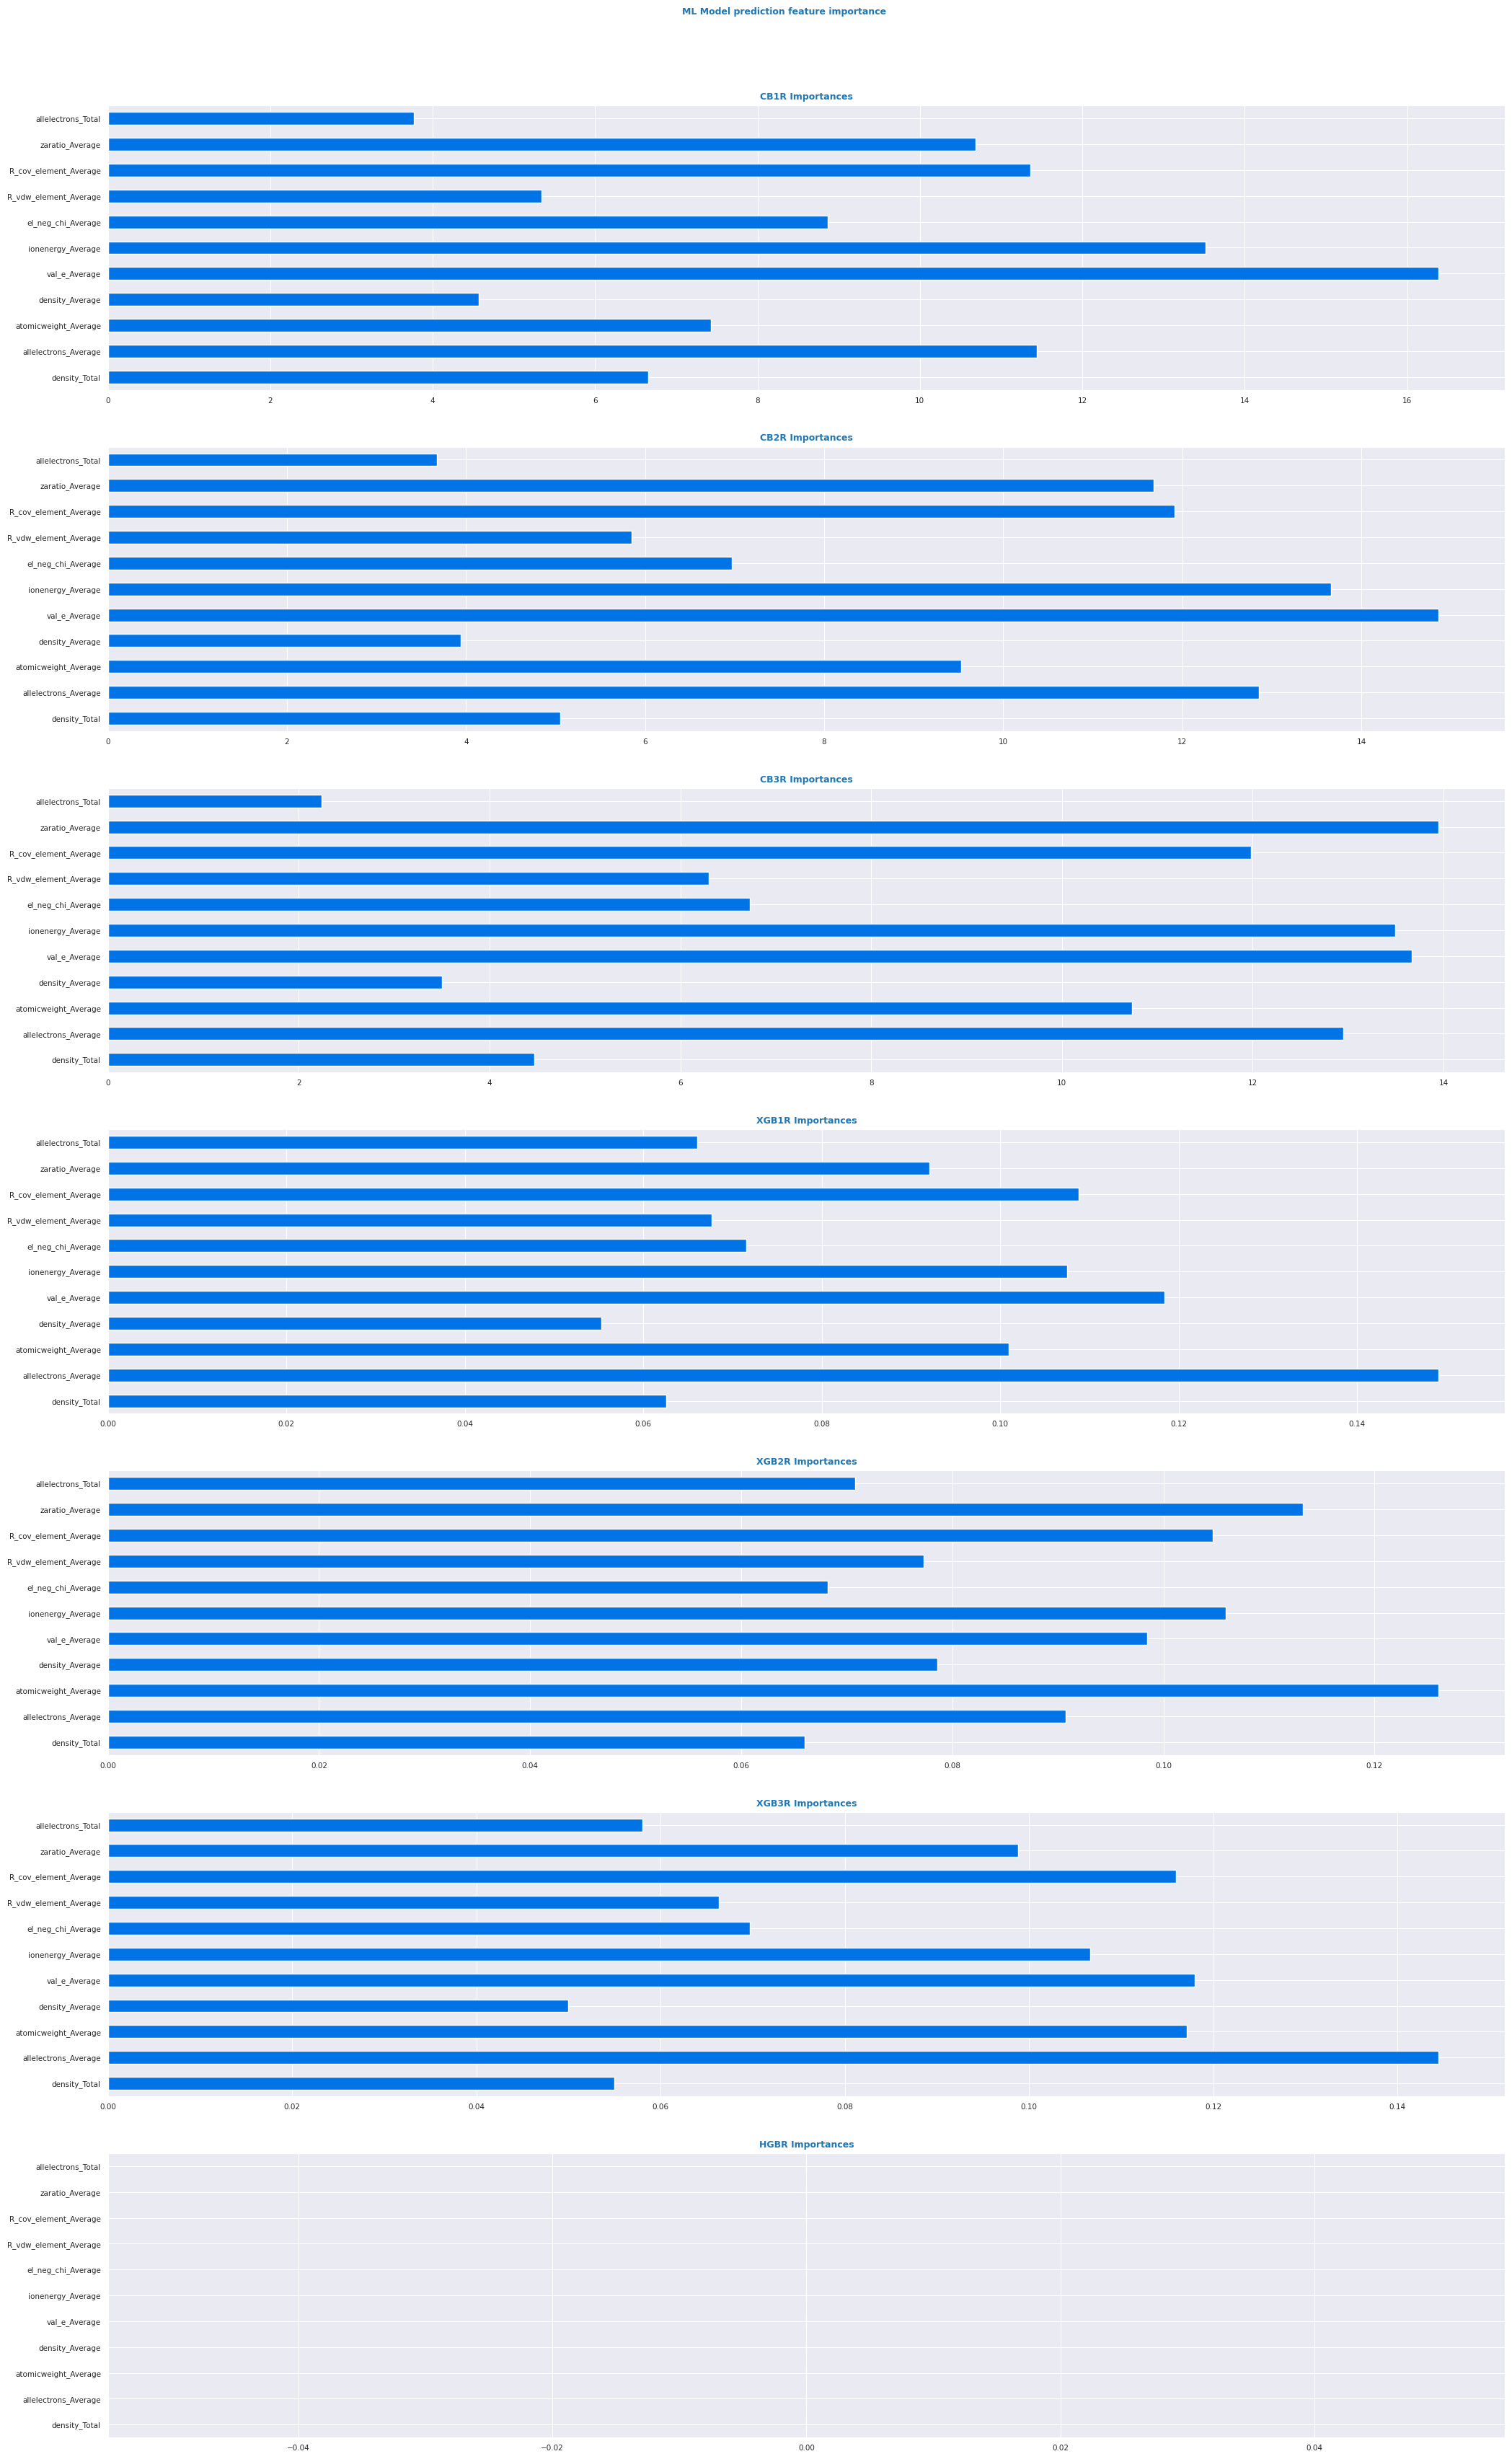

CPU times: user 3.14 s, sys: 303 ms, total: 3.44 s
Wall time: 3.11 s


In [26]:
%%time 

# Analysing the model results and feature importances:-
if CFG.ML == "Y":
    fig, axes = plt.subplots(len(methods), 1, figsize = (25, len(methods) * 6),
                             gridspec_kw = {'hspace': 0.2, 'wspace': 0.2},
                            );
    
    for i, col in enumerate(methods):
        try: 
            ax = axes[i];
        except: 
            ax = axes[0];
        FtreImp[col].plot.barh(ax = ax, color = '#0073e6');
        ax.set_title(f"{col} Importances", **CFG.title_specs);
        ax.set(xlabel = '', ylabel = '');
        
    plt.suptitle(f"ML Model prediction feature importance", y = 0.9125, **CFG.title_specs);
    plt.tight_layout();
    plt.show();  

collect();


## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > INFERENCES<br> <div>

<div style= "font-family: Cambria; letter-spacing: 0px; color:#000000; font-size:110%; text-align:left;padding:3.0px; background: #f2f2f2" >
1. We have to drop some features/ add secondary features to ensue better CV results. Train-OOF scores are very stable. <br>
2. We need to fine-tune some model parameters too<br>
3. We could try other model methods too, perhaps some simpler ones will be good enough <br>
4. Custom objective/ metric class will also work in this case <br>
5. We can explore pseudo labels also <br>
</div>

<a id="8"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > ENSEMBLE AND SUBMISSION<br> <div> 

In [27]:
%%time 

if CFG.ensemble_req == "Y" and CFG.optuna_req == "Y":
    def Objective(trial):
        "This function defines the objective for the optuna ensemble using variable models";

        global OOF_Preds, all_cv, ytrain, methods, y_grp;

        # Define the weights for the predictions from each model:-
        weights  = [trial.suggest_float(f"M{n}", 0.0001, 0.9999, step = 0.001) \
                    for n in range(len(OOF_Preds[methods].columns))
                   ];

        # Calculating the CV-score for the weighted predictions on the competition data only:-
        scores = [];  
        cv     = all_cv[CFG.enscv_mthd];
        X,y    = OOF_Preds[methods], ytrain[0: len(OOF_Preds)];

        for fold_nb, (train_idx, dev_idx) in enumerate(cv.split(X,y_grp[0: len(OOF_Preds)])):
            Xtr, Xdev = X.iloc[train_idx], X.iloc[dev_idx];
            ytr, ydev = y.loc[Xtr.index],  y.loc[Xdev.index];
            scores.append(ScoreMetric(ydev, np.average(Xdev, axis=1, weights = weights)));

        collect();
        clear_output();
        return np.mean(scores);
    
clear_output();
print();
collect();


CPU times: user 150 ms, sys: 1.04 ms, total: 151 ms
Wall time: 150 ms


In [28]:
%%time 

if CFG.ensemble_req == "Y" and CFG.optuna_req == "Y":   
    PrintColor(f"\n{'-' * 20} Creating an Optuna Ensemble {'-' * 20}\n", 
               color = Fore.MAGENTA);   
    
    study = optuna.create_study(direction  = CFG.metric_obj, 
                                study_name = "OptunaEnsemble", 
                                sampler    = TPESampler(seed = CFG.state)
                               );
    study.optimize(Objective, 
                   n_trials          = CFG.ntrials, 
                   gc_after_trial    = True,
                   show_progress_bar = True
                  );
    weights       = study.best_params;
    clear_output();
    
    PrintColor(f"\n--> Post ensemble weights\n");
    pprint(weights, indent = 5, width = 10, depth = 1);
    PrintColor(f"\n--> Best ensemble CV score = {study.best_value :.5f}\n");
    
    # Making weighted predictions on the test set:-
    sub_fl[CFG.target] = np.average(Mdl_Preds[methods], weights = list(weights.values()),
                                    axis=1
                                   ) / CFG.tgt_scl_fct;
    
    # Making OOF predictions:-
    OOF_Preds["Optuna"] = np.average(OOF_Preds[methods], weights = list(weights.values()),
                                     axis=1
                                    ) / CFG.tgt_scl_fct;
    
    PrintColor(f"\n--> Post ensemble test-set predictions\n");
    display(sub_fl.head(5).style.format(precision = 5)); 
      
collect();
print();


CPU times: user 225 ms, sys: 0 ns, total: 225 ms
Wall time: 225 ms


In [29]:
%%time 

if CFG.ensemble_req == "Y" and CFG.LAD_req == "Y":
    PrintColor(f"\n{'-' * 20} Creating an LADR Ensemble {'-' * 20}\n", color = Fore.MAGENTA); 
    X,y        = OOF_Preds[methods], ytrain[0: len(OOF_Preds)];
    model      = LADR();
    test_preds = 0;
    scores     = [];
    cv         = all_cv[CFG.enscv_mthd];
    ens_preds  = pd.DataFrame(columns = ["LAD"]);

    for fold_nb, (train_idx, dev_idx) in enumerate(cv.split(X, y_grp[0:len(X)])):
        Xtr  = X.iloc[train_idx];  
        Xdev = X.iloc[dev_idx]; 
        ytr  = y.loc[y.index.isin(Xtr.index)];
        ydev = y.loc[y.index.isin(Xdev.index)];

        model.fit(Xtr, ytr);
        dev_preds  = PostProcessPred(model.predict(Xdev), CFG.pstprcs_train);
        score      = ScoreMetric(ydev, dev_preds);
        test_preds = test_preds + \
        PostProcessPred(model.predict(Mdl_Preds[methods]), CFG.pstprcs_train);
        scores.append(score);
        
        ens_preds = pd.concat([ens_preds, 
                               pd.DataFrame(dev_preds, columns = ['LAD'], index = Xdev.index)], 
                              axis=0
                             );

    test_preds         = test_preds/ (CFG.n_splits * CFG.n_repeats);
    sub_fl[CFG.target] = test_preds/ CFG.tgt_scl_fct;
    ens_preds          = ens_preds.groupby(level = 0).mean().values;
    OOF_Preds["LAD"]   = ens_preds;
    
    PrintColor(f"---> OOF scores for the LAD ensemble");
    with np.printoptions(linewidth = 160, precision= 4):
        pprint(np.array(scores), indent = 10, depth = 1);
        PrintColor(f"---> Mean OOF scores for the LAD ensemble = {np.mean(scores):.5f}");
        
    PrintColor(f"\n--> Post ensemble test-set predictions\n");
    display(sub_fl.head(5).style.format(precision = 5)); 
    
    # Analyzing the grouped predictions for edge case issues:-  
    PrintColor(f"\n--> Analysis of grouped predictions on OOF data\n");
    OOF_Preds['Grp'] = y_grp[0: len(OOF_Preds)];
    OOF_Preds        = pd.concat([OOF_Preds, ytrain[0: len(OOF_Preds)]], axis=1);
    
    display(OOF_Preds[["Grp", CFG.target, "LAD"]].\
            groupby("Grp").\
            apply(lambda x: ScoreMetric(x[CFG.target], x["LAD"])).\
            to_frame().rename(columns = {0: "OOFScore"}).\
            transpose().\
            style.format(precision = 4).\
            background_gradient("icefire")
           );

print();
collect();


-------------------- Creating an LADR Ensemble --------------------

---> OOF scores for the LAD ensemble
array([49.385 , 55.2816, 51.6895, 48.7006, 53.7274, 50.5147, 60.0994, 49.8303, 51.1113, 48.5014])
---> Mean OOF scores for the LAD ensemble = 51.88411

--> Post ensemble test-set predictions



,id,Hardness
0,10407,2.60062
1,10408,2.60748
2,10409,6.01475
3,10410,4.49172
4,10411,5.31236



--> Analysis of grouped predictions on OOF data



Grp,100,130,150,180,200,229,250,280,290,300,320,330,350,360,380,400,430,450,480,500,530,550,580,600,620,630,650,680,700,730,750,780,800,850,900,950,1000
OOFScore,174.4225,141.4571,127.1242,76.7726,90.2910,63.4706,55.1257,81.9305,88.6638,62.8357,18.5602,70.6905,86.1388,74.3352,70.0988,71.5378,105.5173,99.8540,80.5273,56.3474,45.5567,36.3923,24.7797,18.8449,36.0398,44.2762,71.9726,94.4059,99.0183,141.1115,156.9725,181.6927,229.5821,245.1244,307.8267,311.7522,369.6269



CPU times: user 6.75 s, sys: 4.78 s, total: 11.5 s
Wall time: 3.12 s


In [30]:
%%time 

if CFG.ensemble_req == "Y":
    sub_fl[['id', CFG.target]].to_csv(f"SubNoPP_V{CFG.version_nb}.csv", index = None);
    
    PrintColor(f"\n---> Blending with good public work\n");
    sub_fl['nb1'] = \
    pd.read_csv(f"/kaggle/input/mohs-hardness-eda-transformation-xgboost-ann/submission.csv")[CFG.target].values;
    sub_fl['nb2'] = \
    pd.read_csv(f"/kaggle/input/ps3-25-reg-tf-keras/submission.csv")[CFG.target].values;   
    
    sub_fl[CFG.target] = PostProcessPred(sub_fl[CFG.target] * 0.025 + sub_fl['nb1'] * 0.90 + sub_fl['nb2'] * 0.075, 
                                         "Y", 1);
       
    PrintColor(f"\n---> Submission file- final check after post-processing\n");
    display(sub_fl[CFG.target].describe());
    sub_fl[['id', CFG.target]].to_csv(f"Submission_V{CFG.version_nb}.csv", index = None);
    
    PrintColor(f"\n---> Submission file after post-processing\n");
    display(sub_fl[['id', CFG.target]].head(10).style.format(precision = 3));
    
if CFG.ML == "Y":  
    OOF_Preds.add_prefix(f"V{CFG.version_nb}_").to_csv(f"OOF_Preds_V{CFG.version_nb}.csv");
    Mdl_Preds.add_prefix(f"V{CFG.version_nb}_").to_csv(f"Mdl_Preds_V{CFG.version_nb}.csv"); 
    if isinstance(Scores, pd.DataFrame) == True:
        Scores.to_csv(f"Scores_V{CFG.version_nb}.csv");
          
collect();
print();


---> Blending with good public work


---> Submission file- final check after post-processing



count    6939.000000
mean        4.763138
std         1.479368
min         1.766494
25%         2.955505
50%         5.798810
75%         5.872192
max         6.095305
Name: Hardness, dtype: float64


---> Submission file after post-processing



,id,Hardness
0,10407,2.287
1,10408,4.234
2,10409,5.865
3,10410,5.703
4,10411,5.790
5,10412,5.871
6,10413,3.410
7,10414,5.838
8,10415,2.323
9,10416,5.843



CPU times: user 615 ms, sys: 12.3 ms, total: 627 ms
Wall time: 648 ms


<a id="9"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0052cc; border-bottom: 8px solid #cc9966" > NEXT STEPS<br> <div> 

<div style= "font-family: Cambria; letter-spacing: 0px; color:#000000; font-size:110%; text-align:left;padding:3.0px; background: #f2f2f2" >
1. We will perform a detailed EDA and elicit feature interactions and other relevant insights<br>
2. Model tuning<br>
3. Including other models in the ensemble <br>
4. Better ensemble strategy <br>
5. Any other discussion/ public work based insights <br>
6. Significant improvement on edge predictions <br>
7. <b>Is this a regression challenge? </b>
</div>